In [48]:
import gymnasium as gym
import numpy as np
import random
from gym import Env
from gym.spaces import Discrete, Box
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from collections import deque
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers import Adam



In [49]:
data=pd.read_csv('^NSEI.csv')
print(data)
closingpricedata=data.loc[0:,"Close"]
print(closingpricedata)


def calculateSMA15(timestep):
    SMA15Total=closingpricedata[timestep-14]
    for i in range(14):
        SMA15Total=SMA15Total+closingpricedata[timestep-14+i+1]
    return ((SMA15Total/15)-closingpricedata[timestep])
def calculateSMA30(timestep):
    SMA30Total=closingpricedata[timestep-29]
    for i in range(29):
        SMA30Total=SMA30Total+closingpricedata[timestep-29+i+1]
    return ((SMA30Total/30)-closingpricedata[timestep])
def AverageGain(timestep):
    Averagegain=0
    percentage=0
    if timestep==29:
        for i in range(14):
            if(closingpricedata[timestep-13+i]-closingpricedata[timestep-14+i])*100/closingpricedata[timestep-14+i]<0:
                percentage+=0
            else:
                percentage+=(closingpricedata[timestep-13+i]-closingpricedata[timestep-14+i])*100/closingpricedata[timestep-14+i]
        Averagegain=percentage/14
    else:
        currentGain=(closingpricedata[timestep]-closingpricedata[timestep-1])*100/closingpricedata[timestep-1]
        if currentGain<0:
            currentGain=0
        Averagegain=(AverageGain(timestep-1)*13+currentGain)/14
    return Averagegain 
def AverageLoss(timestep):
    Averageloss=0
    percentage=0
    if timestep==29:
        for i in range(14):
            if(closingpricedata[timestep-13+i]-closingpricedata[timestep-14+i])*100/closingpricedata[timestep-14+i]>0:
                percentage+=0
            else:
                percentage-=(closingpricedata[timestep-13+i]-closingpricedata[timestep-14+i])*100/closingpricedata[timestep-14+i]
        Averageloss=percentage/14
    else:
        currentLoss=(closingpricedata[timestep]-closingpricedata[timestep-1])*100/closingpricedata[timestep-1]
        if currentLoss>0:
            currentLoss=0
        Averageloss=(AverageLoss(timestep-1)*13-currentLoss)/14
    return Averageloss  
def RSI(timestep):
    RS=AverageGain(timestep)/AverageLoss(timestep)    
    return 100-100/(1+RS)
def Buy(state,timestep):
    state['Account Balance']-=closingpricedata[timestep]
    state['Cummulative Holding shares of Stock']+=1
def Sell(state,timestep):
    state['Account Balance']+=closingpricedata[timestep]
    state['Cummulative Holding shares of Stock']-=1
def Hold(state,timestep):
    pass

           Date          Open          High           Low         Close  \
0     9/17/2007   4518.450195   4549.049805   4482.850098   4494.649902   
1     9/18/2007   4494.100098   4551.799805   4481.549805   4546.200195   
2     9/19/2007   4550.250000   4739.000000   4550.250000   4732.350098   
3     9/20/2007   4734.850098   4760.850098   4721.149902   4747.549805   
4     9/21/2007   4752.950195   4855.700195   4733.700195   4837.549805   
...         ...           ...           ...           ...           ...   
3880  7/10/2023  19400.349610  19435.849610  19327.099610  19355.900390   
3881  7/11/2023  19427.099610  19515.099610  19406.449220  19439.400390   
3882  7/12/2023  19497.449220  19507.699220  19361.750000  19384.300780   
3883  7/13/2023  19495.199220  19567.000000  19385.800780  19413.750000   
3884  7/14/2023  19493.449220  19595.349610  19433.500000  19564.500000   

         Adj Close    Volume  
0      4494.649902       0.0  
1      4546.200195       0.0  
2     

In [50]:
observations = ['Account Balance', 'Closing Price of Stock', 'Cummulative Holding shares of Stock',
                    'RSI', 'SMA30', 'SMA15']
actions=[Buy, Sell, Hold]

def make_StockMarket_obs_space(observations):
    lower_obs_bound = {
        'Account Balance': 0,
        'Closing Price of Stock': 0,
        'Cummulative Holding shares of Stock': 0,
        'RSI': 0,
        'SMA30': -np.inf,
        'SMA15': -np.inf
    }
    higher_obs_bound = {
        'Account Balance': np.inf,
        'Closing Price of Stock': np.inf,
        'Cummulative Holding shares of Stock': np.inf,
        'RSI': 100,
        'SMA30': np.inf,
        'SMA15': np.inf
    }

    low = np.array([lower_obs_bound[o] for o in observations])
    high = np.array([higher_obs_bound[o] for o in observations])
    shape = (len(observations),)
    return gym.spaces.Box(low,high,shape)

In [51]:
timestep=1500
class StockMarket(Env):
    def __init__(self):
        self.actions=actions
        self.observations=observations
        self.action_space=Discrete(3)
        self.observation_space=make_StockMarket_obs_space(observations)
        self.log=''
    def observation(self):
        return np.array([self.state[o] for o in self.observations])
        
    def step(self,action):
        global timestep
        timestep+=1
        self.state['Closing Price of Stock']=closingpricedata[timestep]
        self.state['RSI']=RSI(timestep)
        self.state['SMA15']=calculateSMA15(timestep)
        self.state['SMA30']=calculateSMA30(timestep)
        Asset=self.state['Account Balance']+self.state['Cummulative Holding shares of Stock']*closingpricedata[timestep-1]
        self.actions[action](self.state,timestep)
        self.log += f'Chosen action: {self.actions[action].__name__}\n'
        reward=((self.state['Account Balance']+self.state['Cummulative Holding shares of Stock']*closingpricedata[timestep])-Asset)*100/Asset
        profitpercentage=reward
        if self.state['Account Balance']+self.state['Cummulative Holding shares of Stock']*closingpricedata[timestep]<98000:
            reward=-200
        return self.observation(), reward, False, {"Asset": self.state['Account Balance']+self.state['Cummulative Holding shares of Stock']*closingpricedata[timestep],"RSI": self.state['RSI'],"Profit Percentage": profitpercentage}
    
        
    def reset(self):
        timestep=1500
        self.state = {
            'Account Balance': 100000,
            'Closing Price of Stock': closingpricedata[1500],
            'Cummulative Holding shares of Stock': 0,
            'RSI': RSI(1500),
            'SMA30': calculateSMA15(1500),
            'SMA15': calculateSMA30(1500)
        }
        return self.observation()
    def close(self):
        pass
        
    def render(self, mode=None):
        print(self.log)
        self.log = ''
    

In [52]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 0.5  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.learning_rate = 0.005
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        print(act_values)
        return np.argmax(act_values[0])  # returns action
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

    
    

episode: 1/500, reward:0.0, action:1, RSI:60.14067170744354
episode: 2/500, reward:0.02789990200000466, action:0, RSI:57.571662798683334
episode: 3/500, reward:0.0, action:1, RSI:53.454742321715734
1/1 [==============================] - 0s 164ms/step
[[ 26129.834 -34068.523  25609.906]]
episode: 4/500, reward:0.06193291577719004, action:0, RSI:48.44658952647736
1/1 [==============================] - 0s 32ms/step
[[ 24625.86 -32198.29  24147.73]]
episode: 5/500, reward:0.0, action:0, RSI:44.04435248611501
episode: 6/500, reward:-0.028424167857600987, action:0, RSI:42.09573509547751
1/1 [==============================] - 0s 24ms/step
[[ 21654.604 -28511.852  21272.979]]
episode: 7/500, reward:0.13301793446945534, action:0, RSI:47.92697329767603
episode: 8/500, reward:0.3977766184850028, action:2, RSI:57.11037308084994
1/1 [==============================] - 0s 52ms/step
[[ 20153.826 -26709.846  19904.21 ]]
episode: 9/500, reward:0.04279648929526923, action:0, RSI:57.954416633717116
episod

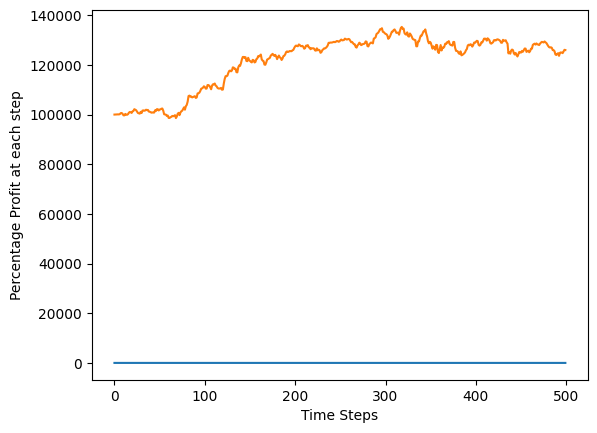

In [53]:
EPISODES=500
if __name__ == "__main__":
    env = StockMarket()
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    #agent.load("./StockMarket-dqn2.h5")
    done = False
    batch_size = 32
    state = env.reset()
    rewards=[]
    outcomes=["Profit"]
    Assets=[]
    actions=[]
    for e in range(EPISODES):
        
        state = np.reshape(state, [1, state_size])
        
        # env.render()
        action = agent.act(state)
        next_state, reward, done, asset = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.memorize(state, action, reward, next_state, done)
        state = next_state
        rewards.append(asset['Profit Percentage'])
        actions.append(action)
        print("episode: {}/{}, reward:{}, action:{}, RSI:{}".format(e+1, EPISODES, reward, action, asset['RSI']))
        if reward>=0:
            outcomes[-1]="Profit"
        elif reward<0:
            outcomes[-1]="Loss"
        Assets.append(asset['Asset'])
        #if len(agent.memory) > batch_size:
        #    agent.replay(batch_size)
        if e % 10 == 0:
            agent.save("./StockMarket-dqn2.h5")
    print(rewards)
    plt.plot(rewards)
    plt.plot(Assets)   
    plt.xlabel('Time Steps')
    plt.ylabel('Percentage Profit at each step')
    

<BarContainer object of 3 artists>

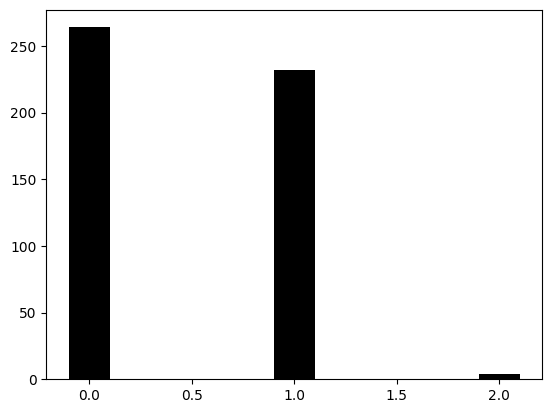

In [55]:
profit=0
loss=0
neutral=0
meanprofitpercentage=[]
totalpercentageprofit=0
for i in range(500):
    if rewards[i]>0:
        profit+=1
    elif rewards[i]<0:
        loss+=1
    else:
        neutral+=1
    totalpercentageprofit+=rewards[i]
    meanprofitpercentage.append(totalpercentageprofit/(i+1))
outcomes=[profit,loss,neutral]
plt.bar(range(len(outcomes)), outcomes, color='black', width=0.2)

[100000.0, 100027.899902, 100027.899902, 100089.850097, 100089.850097, 100061.40039000001, 100194.499998, 100593.050292, 100636.100586, 100314.299802, 99695.049317, 99680.65087700001, 100280.15039200001, 99942.650392, 99928.650392, 100171.900392, 100761.650392, 101053.900392, 100941.900392, 100655.60107100001, 101296.800295, 101447.19872700001, 102175.19872700001, 101957.850099, 101758.24853099999, 101191.447755, 100642.24853099999, 100518.951168, 100378.097658, 101080.99853099999, 100626.49853099999, 101594.899413, 101687.149413, 101542.248531, 101647.24853099999, 101961.347658, 101779.750002, 101882.949218, 101220.148434, 101140.148434, 100982.550778, 100748.949218, 100860.10010000001, 100803.85010000001, 100831.750973, 101743.449218, 101465.35010000001, 102176.798336, 102158.798336, 101643.548336, 102024.250973, 102112.897463, 102364.401363, 102438.09814, 101570.199218, 100130.30029599999, 100024.699218, 99958.699218, 99446.651363, 99620.449218, 98655.747073, 98644.948237, 98924.448

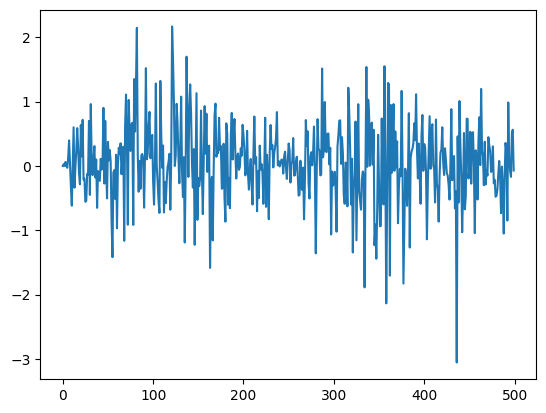

In [57]:
plt.plot(rewards)
print(Assets)
print(actions)

Text(0.5, 0, 'Time steps')

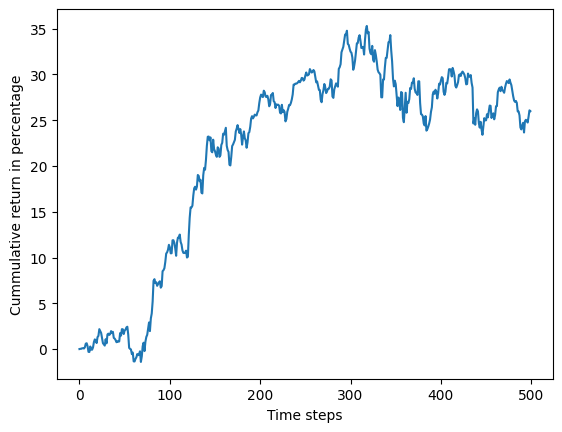

In [56]:
cummulativereturn=[]
for i in range(500):
    cummulativereturn.append((Assets[i]-100000)*100/100000)
plt.plot(cummulativereturn)
plt.ylabel("Cummulative return in percentage")
plt.xlabel("Time steps")

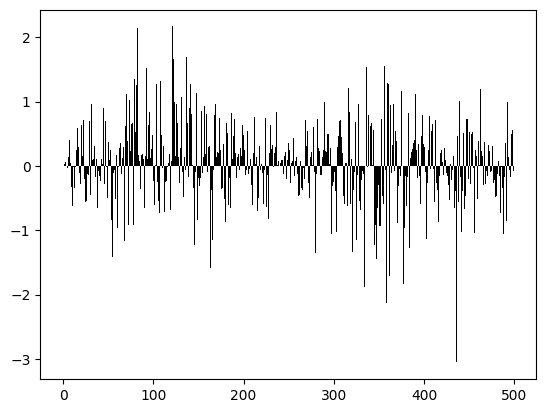

Text(0, 0.5, 'Mean Profit Percentage at each step')

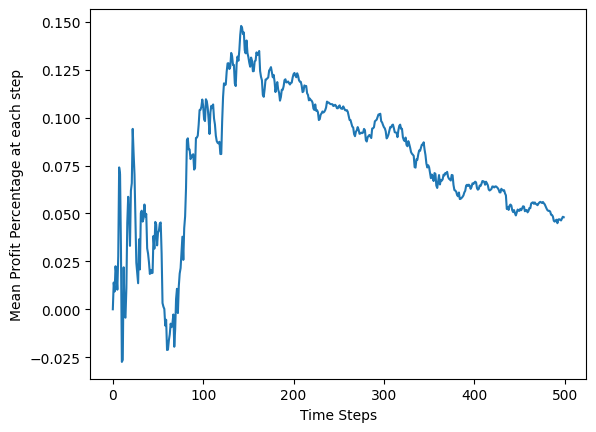

In [58]:
plt.bar(range(len(rewards)), rewards, color='black', width=1)
plt.show()
plt.plot(meanprofitpercentage)   
plt.xlabel('Time Steps')
plt.ylabel('Mean Profit Percentage at each step')
#env=StockMarket()
#rewards=[]
#env.reset()
#env.render()
#for i in range(200):
#   action=env.action_space.sample()
#  new_state, reward, truncated, info=env.step(action)
#  rewards.append(reward)
#  print(action)
#print(rewards)
#plt.plot(rewards)
#plt.xlabel('Time Steps')
#plt.ylabel('Percentage Profit at each step')